In [126]:
import load_dtypes as ld
import warnings
warnings.filterwarnings(action='ignore')
import os, sys

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor

In [127]:
TRAIN_PATH = r'C:\Users\Wyatt\wyatt37\Data\solarpanel\train\train.csv'
TEST_PATH = r'C:\Users\Wyatt\wyatt37\Data\solarpanel\test'
SUBMISSION_PATH = r'C:\Users\Wyatt\wyatt37\Data\solarpanel\sample_submission.csv'

In [128]:
train = ld.load_dtypes(TRAIN_PATH)
train.info()
submission = pd.read_csv(SUBMISSION_PATH)

C:\Users\Wyatt\wyatt37\Data\solarpanel\train\train.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52560 entries, 0 to 52559
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Day     52560 non-null  int16  
 1   Hour    52560 non-null  int8   
 2   Minute  52560 non-null  int8   
 3   DHI     52560 non-null  int16  
 4   DNI     52560 non-null  int16  
 5   WS      52560 non-null  float32
 6   RH      52560 non-null  float32
 7   T       52560 non-null  int8   
 8   TARGET  52560 non-null  float32
dtypes: float32(3), int16(3), int8(3)
memory usage: 1.1 MB


In [129]:
# hour와 minute을 합쳐주는 함수입니다.
def sum_hour_minute(train):
    # 0과 30으로 되어 있는 minute을 0과 0.5로 바꿉니다.
    train.Minute = round(train.Minute * 0.017, 1)
    # hour에 minute을 더해줍니다.
    train.Hour = train.Hour + train.Minute
    
    return train

In [130]:
# 최종적으로 파생변수 만드는 함수
def make_features(train):
    print("original_shape: ", train.shape)
    # hour와 minute 합쳐줍니다.
    train = sum_hour_minute(train)
    
    #-------------------- 파생변수 생성하면 이 아래에 추가

    #----------------------------------------------------
    train.drop(['Day', 'Minute'], axis=1, inplace=True)  
    
    print("feature_creationed: ", train.shape)
    
    return train

In [131]:
train = make_features(train)
train

original_shape:  (52560, 9)
feature_creationed:  (52560, 7)


,Hour,DHI,DNI,WS,RH,T,TARGET
0,0.0,0,0,1.5,69.080002,-12,0.0
1,0.5,0,0,1.5,69.059998,-12,0.0
2,1.0,0,0,1.6,71.779999,-12,0.0
3,1.5,0,0,1.6,71.750000,-12,0.0
4,2.0,0,0,1.6,75.199997,-12,0.0
...,...,...,...,...,...,...,...
52555,21.5,0,0,2.4,70.699997,-4,0.0
52556,22.0,0,0,2.4,66.790001,-4,0.0
52557,22.5,0,0,2.2,66.779999,-4,0.0
52558,23.0,0,0,2.1,67.720001,-4,0.0


In [132]:
train.DNI[:48]

0       0
1       0
2       0
3       0
4       0
5       0
6       0
7       0
8       0
9       0
10      0
11      0
12      0
13      0
14      0
15      0
16    494
17      7
18    743
19    811
20    368
21    224
22    261
23    364
24     37
25    133
26    114
27    101
28      2
29     69
30      0
31     39
32     11
33      0
34      0
35      0
36      0
37      0
38      0
39      0
40      0
41      0
42      0
43      0
44      0
45      0
46      0
47      0
Name: DNI, dtype: int16

In [133]:
train.DNI[48:96]

48      0
49      0
50      0
51      0
52      0
53      0
54      0
55      0
56      0
57      0
58      0
59      0
60      0
61      0
62      0
63      0
64    519
65    690
66    799
67      0
68    910
69    938
70    961
71    972
72    980
73    978
74    972
75    958
76    936
77    902
78    852
79    772
80    641
81    389
82      0
83      0
84      0
85      0
86      0
87      0
88      0
89      0
90      0
91      0
92      0
93      0
94      0
95      0
Name: DNI, dtype: int16

# shift-window

하루씩 줄여가며 가보겠습니다. 테스트 데이터를 덜 쓴다는 단점이 있는데, 이것이 어떻게 작용할지 살펴봐야겠습니다.

In [134]:
shifted_columns = train.columns[1:]
lags = [48, 96, 144, 192, 240] # 뒤에서부터 하나씩 줄인다.

In [135]:
def shift_columns(data, shifted_columns, lags):
    
    temp = data.copy()
    for lag in lags:
        for col in shifted_columns:
            temp[col + '_lag_%s'%lag] = temp[col].shift(lag)
            
    return temp

In [136]:
train = shift_columns(train, shifted_columns, lags)
train.shape

(52560, 37)

In [137]:
# 타겟값을 미리 만들어줘야 합니다.
train['TARGET_1'] = train.TARGET.shift(-48)
train['TARGET_2'] = train.TARGET_1.shift(-48)

In [138]:
train.dropna(inplace=True)
train.shape

(52224, 39)

In [139]:
X = train[:35040]
val = train[35040:]

In [140]:
def make_train_test_val(X, val, features):

    x_train = X[features]
    y_train_1 = X['TARGET_1']
    y_train_2 = X['TARGET_2']

    x_val = val[features]
    y_val_1 = val['TARGET_1']
    y_val_2 = val['TARGET_2']
    
    print(x_train.shape)
    
    return x_train, y_train_1, y_train_2, x_val, y_val_1, y_val_2

In [141]:
x_train, y_train_1, y_train_2, x_val, y_val_1, y_val_2 = make_train_test_val(X, val, X.columns[:-2])

(35040, 37)


In [142]:
class HiddenPrints: # print를 막아주는 클래스 입니다.
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout
        
with HiddenPrints():
    df_test = []

    for i in range(81):
        file_path = TEST_PATH + '/' + str(i) + '.csv'
        temp = pd.read_csv(file_path)
        temp = make_features(temp)
        temp = shift_columns(temp, shifted_columns, lags).dropna()[-48:]
        df_test.append(temp)

    X_test = pd.concat(df_test)
print(X_test.shape)

(3888, 37)


In [143]:
X_test

,Hour,DHI,DNI,WS,RH,T,TARGET,DHI_lag_48,DNI_lag_48,WS_lag_48,RH_lag_48,T_lag_48,TARGET_lag_48,DHI_lag_96,DNI_lag_96,WS_lag_96,RH_lag_96,T_lag_96,TARGET_lag_96,DHI_lag_144,DNI_lag_144,WS_lag_144,RH_lag_144,T_lag_144,TARGET_lag_144,DHI_lag_192,DNI_lag_192,WS_lag_192,RH_lag_192,T_lag_192,TARGET_lag_192,DHI_lag_240,DNI_lag_240,WS_lag_240,RH_lag_240,T_lag_240,TARGET_lag_240
288,0.0,0,0,0.8,80.92,-2.8,0.0,0.0,0.0,2.1,52.83,-4.4,0.0,0.0,0.0,2.4,57.25,-6.0,0.0,0.0,0.0,1.1,59.09,0.1,0.0,0.0,0.0,1.3,40.27,3.1,0.0,0.0,0.0,1.7,26.93,3.6,0.0
289,0.5,0,0,0.9,81.53,-2.9,0.0,0.0,0.0,2.0,54.44,-4.8,0.0,0.0,0.0,2.4,57.25,-6.0,0.0,0.0,0.0,1.2,61.20,-0.4,0.0,0.0,0.0,1.3,40.55,3.0,0.0,0.0,0.0,1.7,27.12,3.5,0.0
290,1.0,0,0,1.0,79.91,-3.0,0.0,0.0,0.0,1.9,52.78,-5.1,0.0,0.0,0.0,2.5,55.26,-6.1,0.0,0.0,0.0,1.3,65.76,-0.8,0.0,0.0,0.0,1.2,40.27,2.9,0.0,0.0,0.0,1.7,28.00,3.4,0.0
291,1.5,0,0,0.9,79.91,-3.0,0.0,0.0,0.0,1.8,53.59,-5.3,0.0,0.0,0.0,2.5,55.26,-6.1,0.0,0.0,0.0,1.4,66.24,-0.9,0.0,0.0,0.0,1.2,40.56,2.8,0.0,0.0,0.0,1.7,28.40,3.2,0.0
292,2.0,0,0,0.9,77.20,-3.0,0.0,0.0,0.0,1.7,52.63,-5.5,0.0,0.0,0.0,2.6,54.25,-6.0,0.0,0.0,0.0,1.5,69.70,-1.0,0.0,0.0,0.0,1.2,41.81,2.6,0.0,0.0,0.0,1.7,30.53,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,21.5,0,0,0.8,63.35,13.7,0.0,0.0,0.0,0.5,74.13,12.5,0.0,0.0,0.0,1.0,61.43,13.1,0.0,0.0,0.0,1.1,79.32,12.2,0.0,0.0,0.0,0.8,64.85,11.1,0.0,0.0,0.0,1.2,68.24,9.3,0.0
332,22.0,0,0,0.7,64.82,13.1,0.0,0.0,0.0,0.7,73.54,12.0,0.0,0.0,0.0,1.0,62.61,12.5,0.0,0.0,0.0,1.2,80.41,11.7,0.0,0.0,0.0,1.0,66.71,10.3,0.0,0.0,0.0,1.2,69.78,8.7,0.0
333,22.5,0,0,0.7,66.10,12.8,0.0,0.0,0.0,0.9,75.01,11.7,0.0,0.0,0.0,1.0,64.77,12.0,0.0,0.0,0.0,1.1,83.10,11.2,0.0,0.0,0.0,1.2,68.97,9.8,0.0,0.0,0.0,1.3,71.70,8.3,0.0
334,23.0,0,0,0.6,67.64,12.4,0.0,0.0,0.0,1.1,74.47,11.3,0.0,0.0,0.0,1.0,65.31,11.5,0.0,0.0,0.0,1.1,84.37,10.8,0.0,0.0,0.0,1.3,69.70,9.3,0.0,0.0,0.0,1.4,71.52,7.9,0.0


# Train & Predict

In [160]:
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Get the model and the predictions in (a) - (b)
def LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test):
    
    # (a) Modeling  
    model = LGBMRegressor(objective='quantile', # quantile로 받아줘야 quatile regression이 가능합니다.
                          alpha=q, # 이건 나중에 quantile 받을 인자입니다.
                          n_estimators=10000, # 10000만번을 돌리겠다고? 미쳤어?
                          bagging_fraction=0.7,
                          learning_rate=0.027,
                          subsample=0.7)                   
                         
                         
    model.fit(X_train,
              Y_train,
              eval_metric = ['quantile'],
              eval_set=[(X_valid, Y_valid)],
              early_stopping_rounds=300, verbose=500) # 대신 얼리 스토핑을 넣었네요.

    # (b) Predictions
    pred = pd.Series(model.predict(X_test).round(2))
    return pred, model

# Target 예측

def train_data(X_train, Y_train, X_valid, Y_valid, X_test):

    LGBM_models=[]
    LGBM_actual_pred = pd.DataFrame()

    for q in quantiles: # 9번 반복할 겁니다. quantile 마다.
        print(q)
        pred , model = LGBM(q, # 퀀틸 박아줍니다.
                            X_train, Y_train, X_valid, Y_valid, X_test)
        LGBM_models.append(model) # 모델을 어펜드 해줍니다.
        LGBM_actual_pred = pd.concat([LGBM_actual_pred,pred],axis=1) #pred를 컨캣해줍니다.

    LGBM_actual_pred.columns=quantiles # 컬럼은 퀀틸로 박아줍니다.
    
    return LGBM_models, LGBM_actual_pred

In [16]:
quantiles = [0.1, 0.2, 0.3, 0.4 , 0.5, 0.6, 0.7, 0.8, 0.9]

# Get the model and the predictions in (a) - (b)
def GBM(q):
    # (a) Modeling  
    mod = GradientBoostingRegressor(loss='quantile',
                                    alpha=q,
                                    n_estimators=5000,
                                    learning_rate=0.027)
    mod.fit(X_train, y_train,
           eval_metric = ['quantile'])

    # (b) Predictions
    pred = pd.Series(mod.predict(X_test).round(2))
    return pred, mod

In [28]:
quantiles = [0.1, 0.2, 0.3, 0.4 , 0.5, 0.6, 0.7, 0.8, 0.9]

# Get the model and the predictions in (a) - (b)
def CATB(q):
    # (a) Modeling  
    mod = CatBoostRegressor(loss_function='quantile',
                                    alpha=q,
                                    n_estimators=5000,
                                    learning_rate=0.027)
    mod.fit(X_train, y_train,
           eval_metric = ['quantile'])

    # (b) Predictions
    pred = pd.Series(mod.predict(X_test).round(2))
    return pred, mod

(loss_function='Quantile:alpha=0.95', ...)

In [161]:
# Target1
models_1, results_1 = train_data(x_train, y_train_1, x_val, y_val_1, X_test)

# Target2
#models_2, results_2 = train_data(x_train, y_train_2, x_val, y_val_2, X_test)

0.1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[105]	valid_0's quantile: 1.45229
0.2
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[150]	valid_0's quantile: 2.34309
0.3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.78376
Early stopping, best iteration is:
[234]	valid_0's quantile: 2.77003
0.4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2

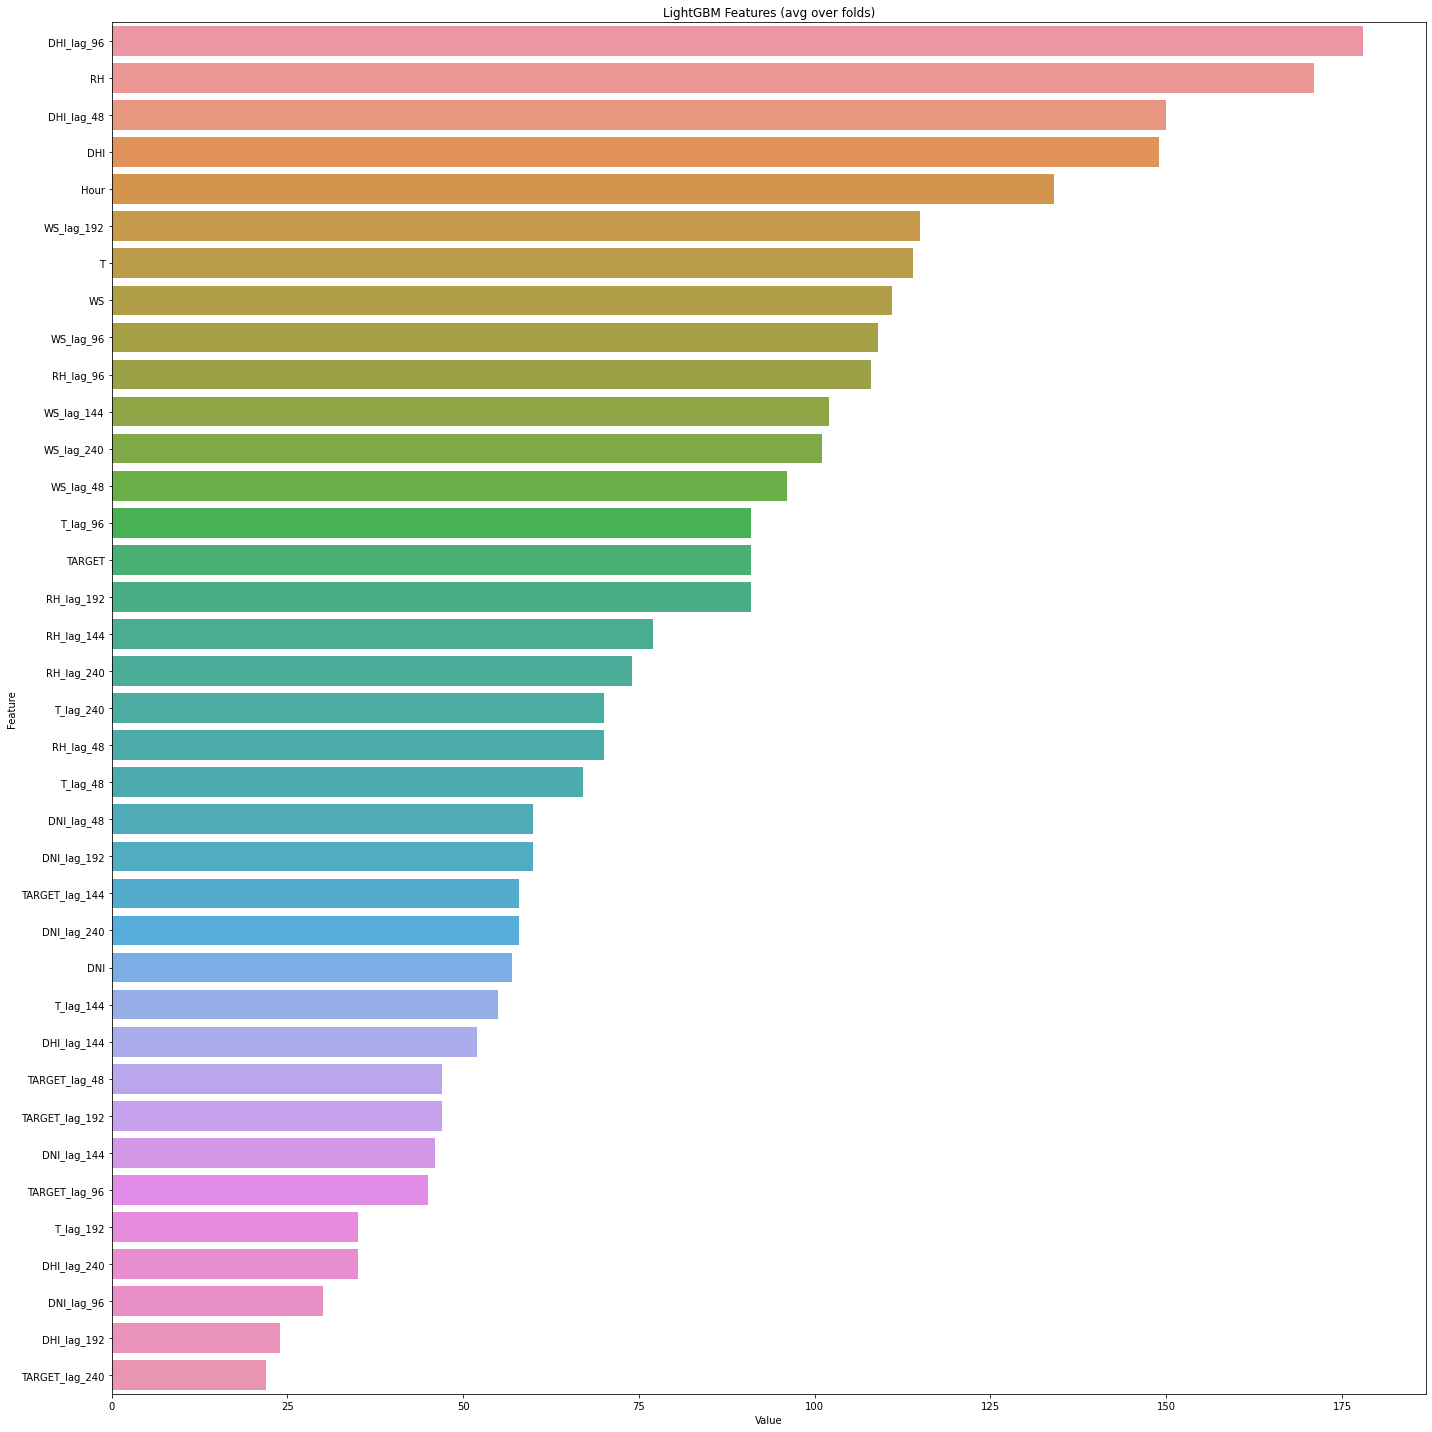

<Figure size 432x288 with 0 Axes>

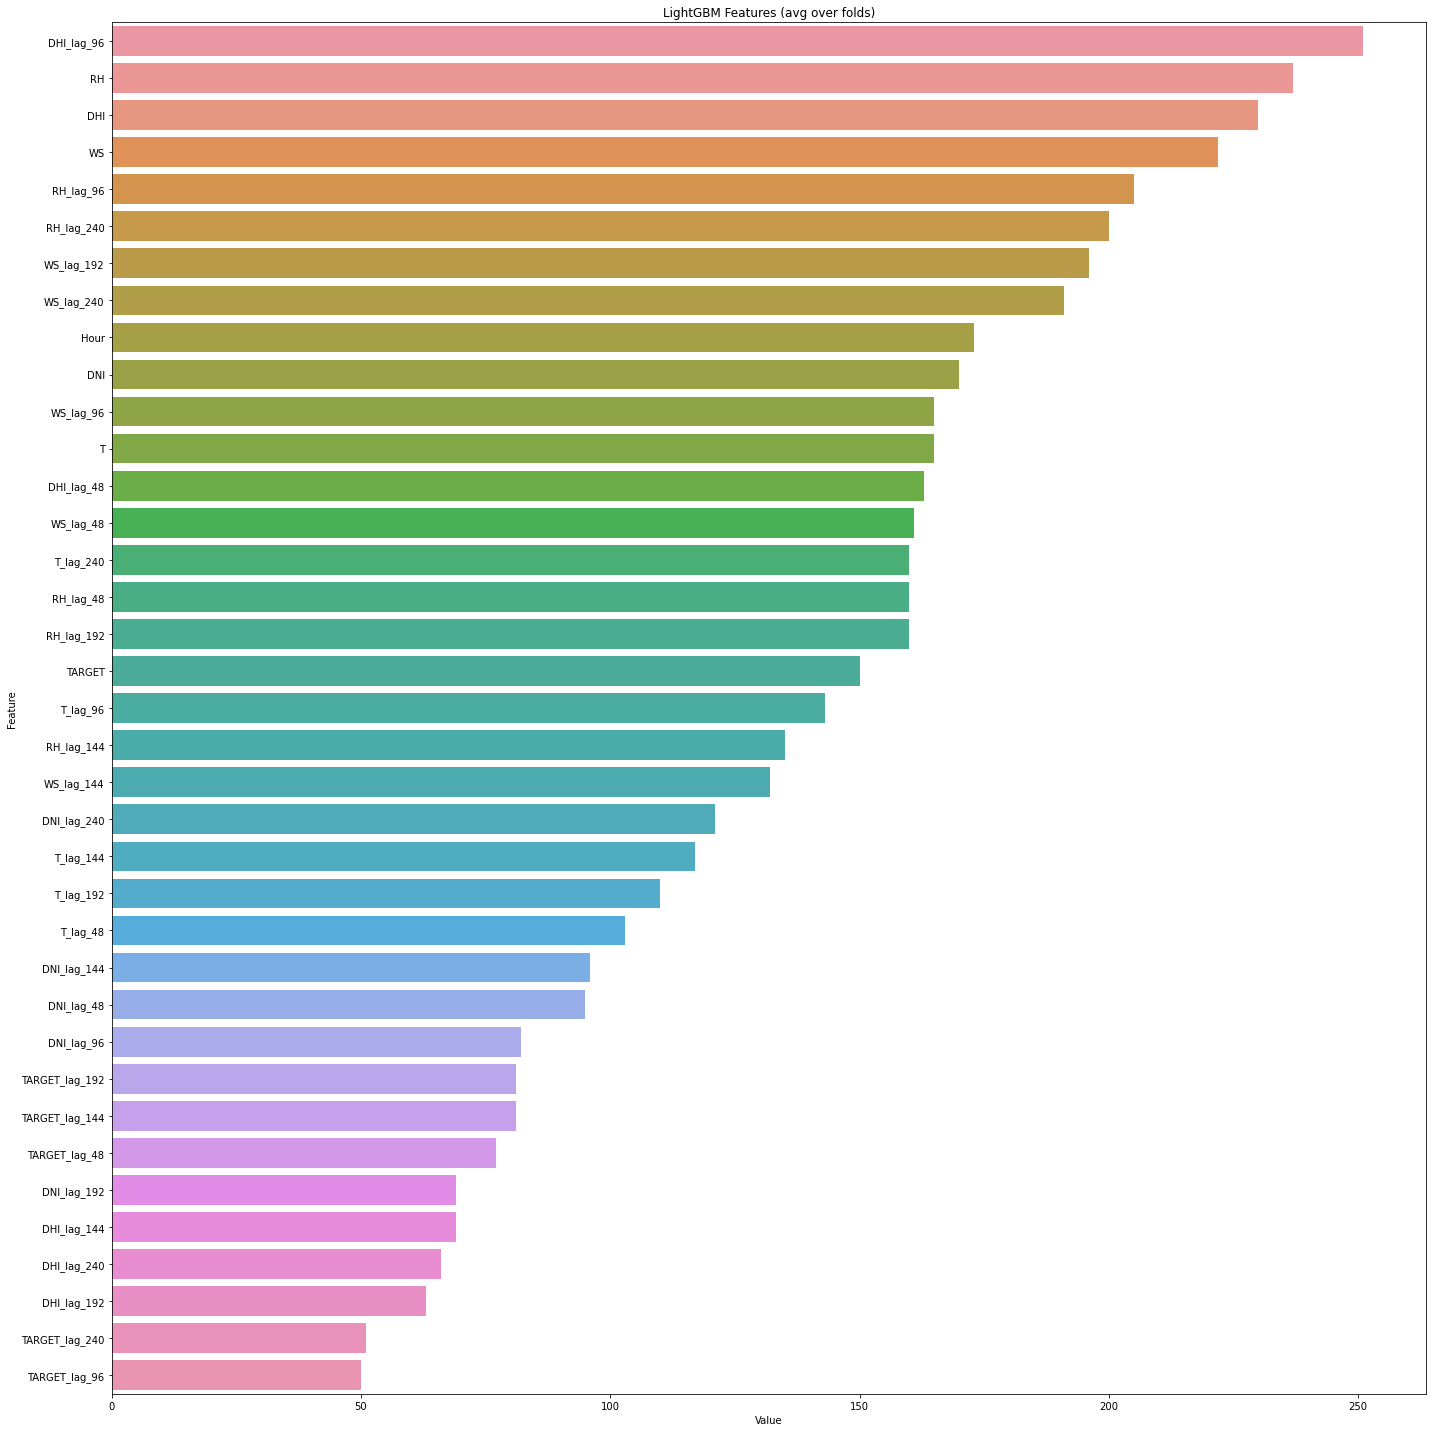

<Figure size 432x288 with 0 Axes>

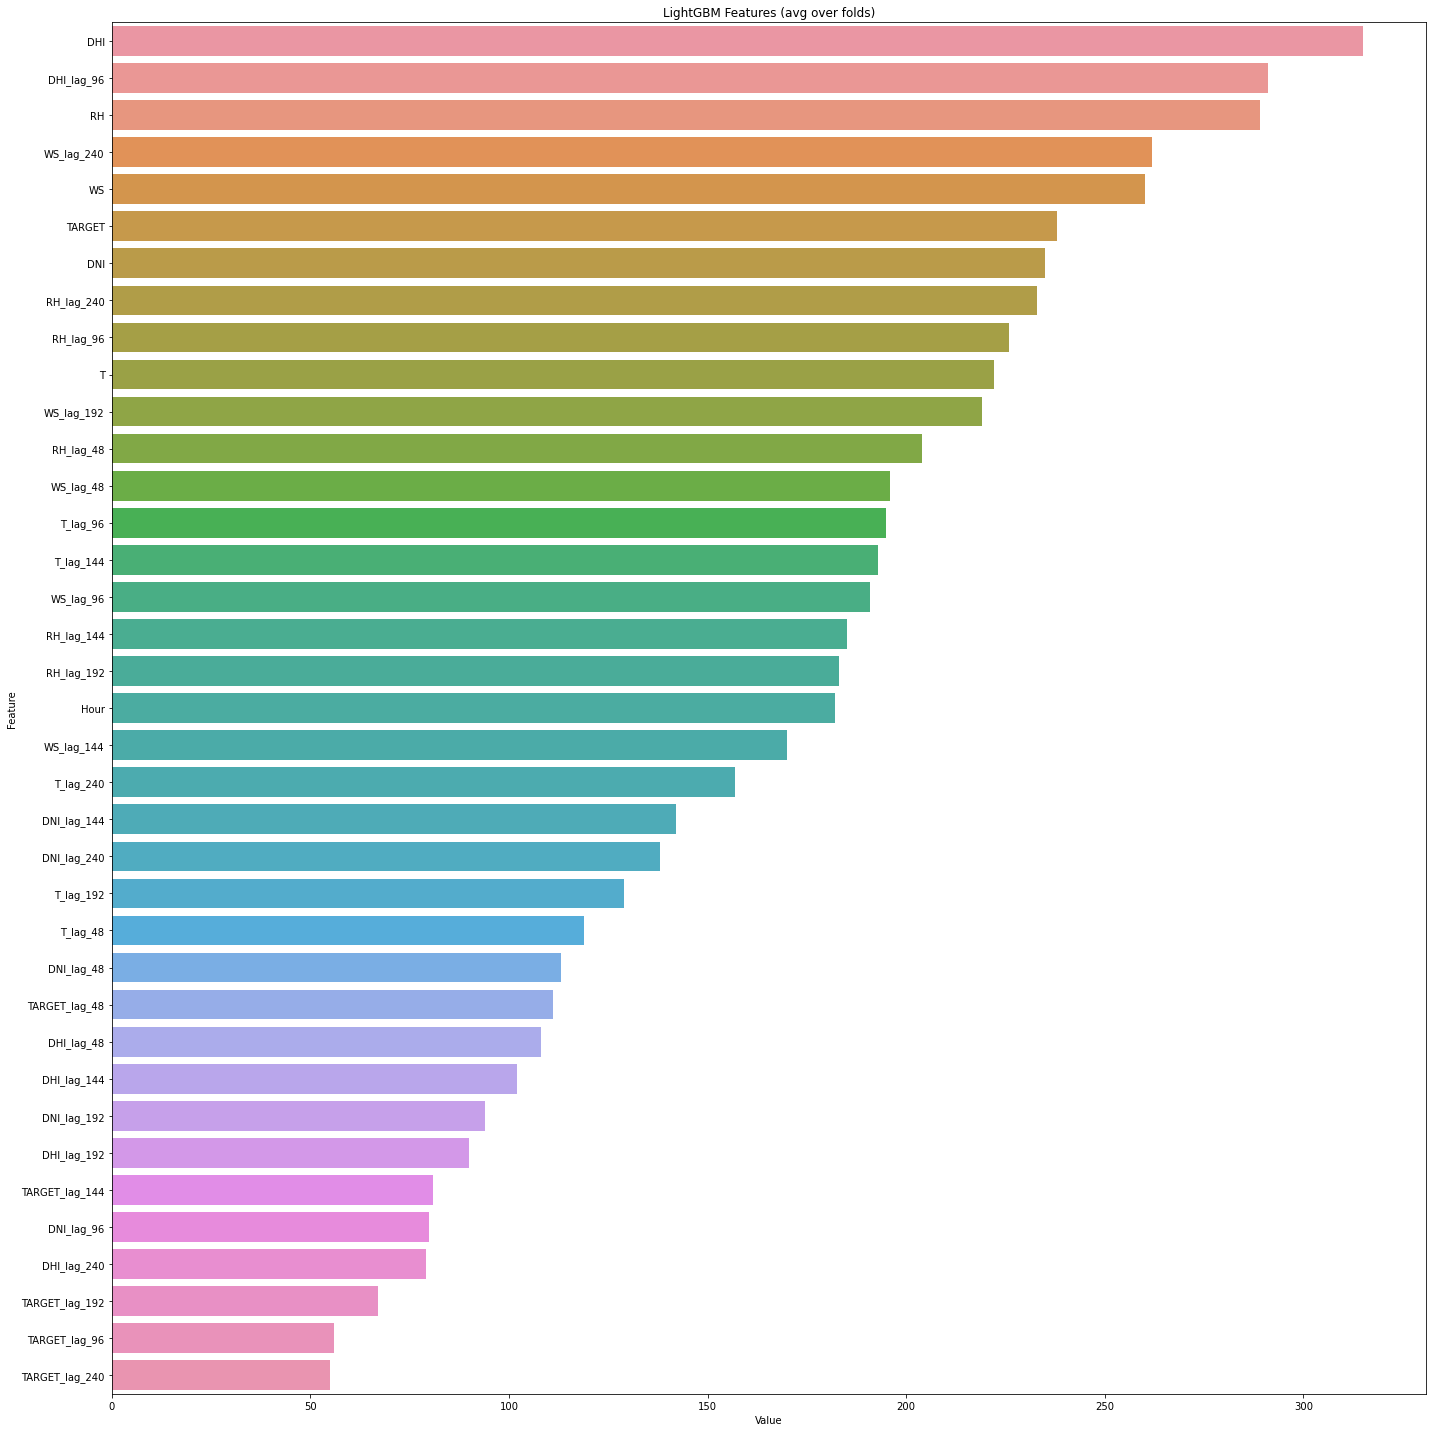

<Figure size 432x288 with 0 Axes>

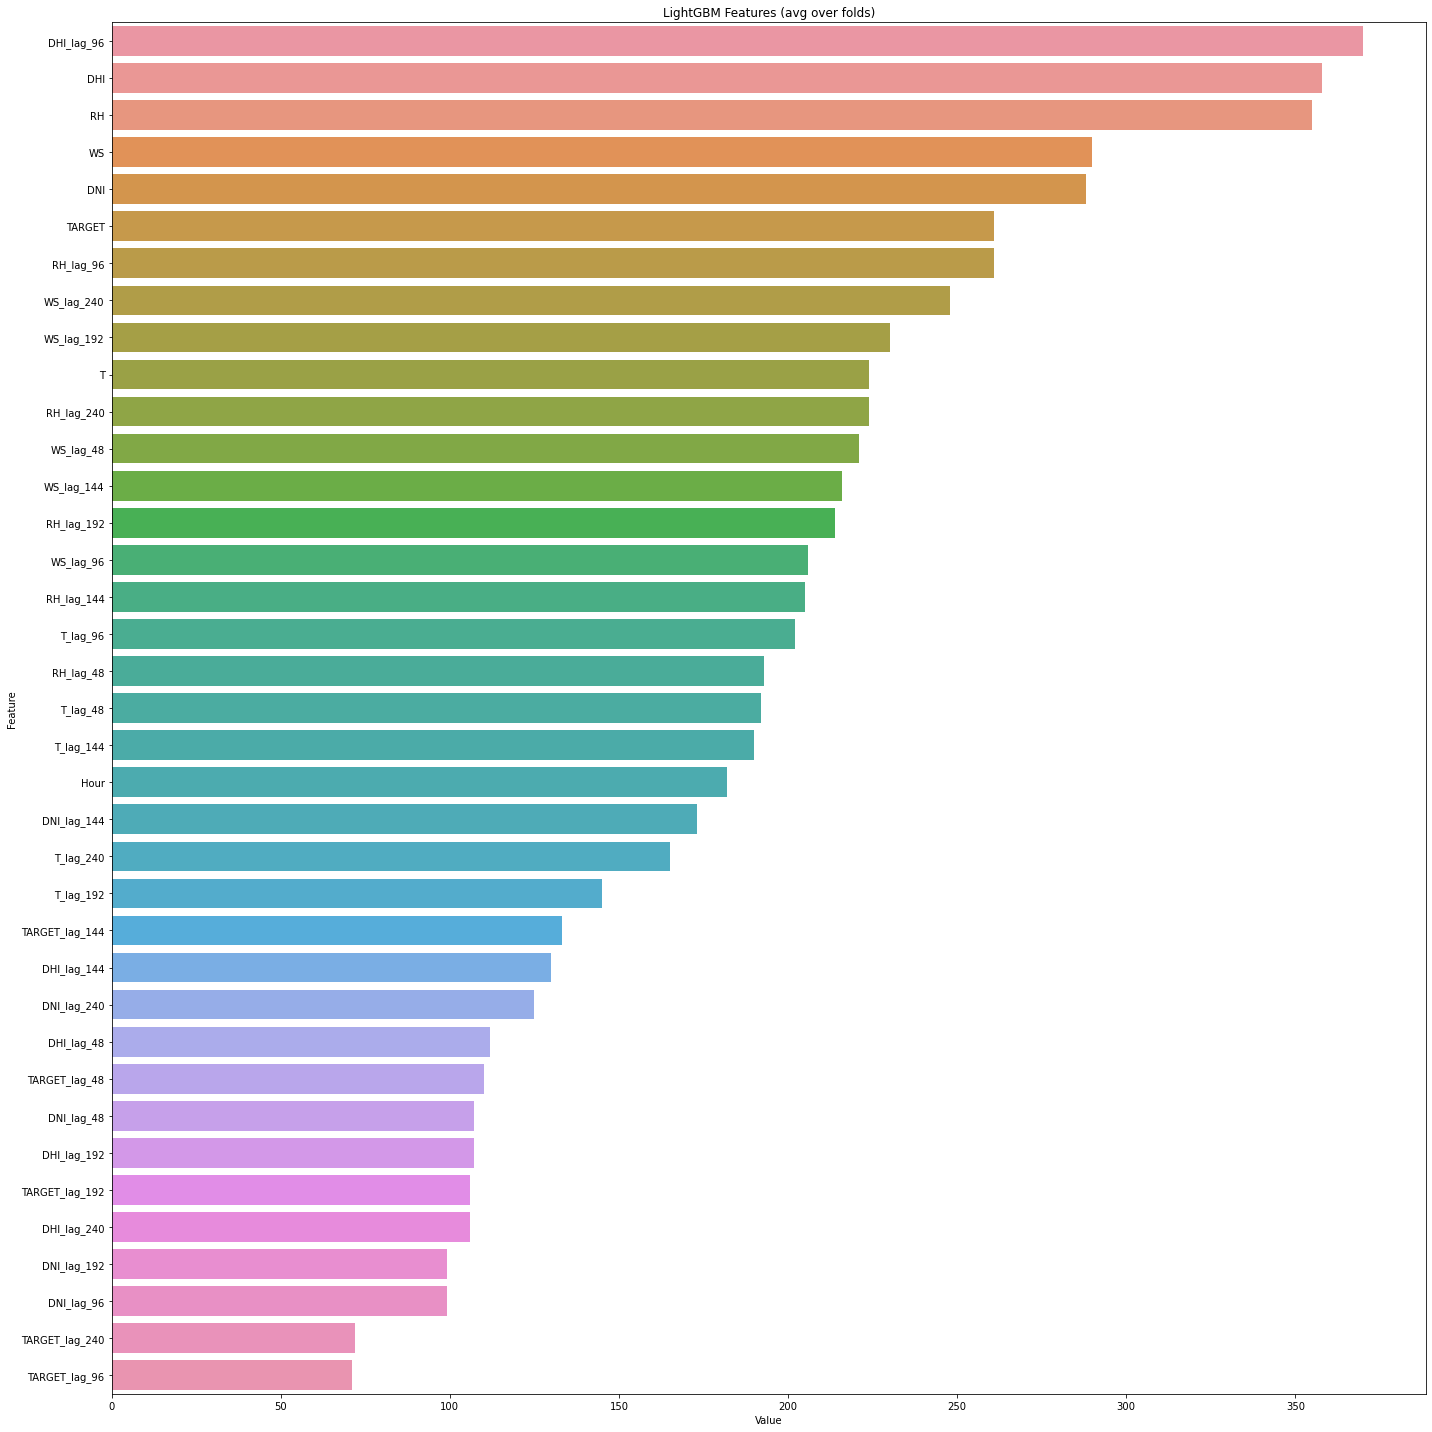

<Figure size 432x288 with 0 Axes>

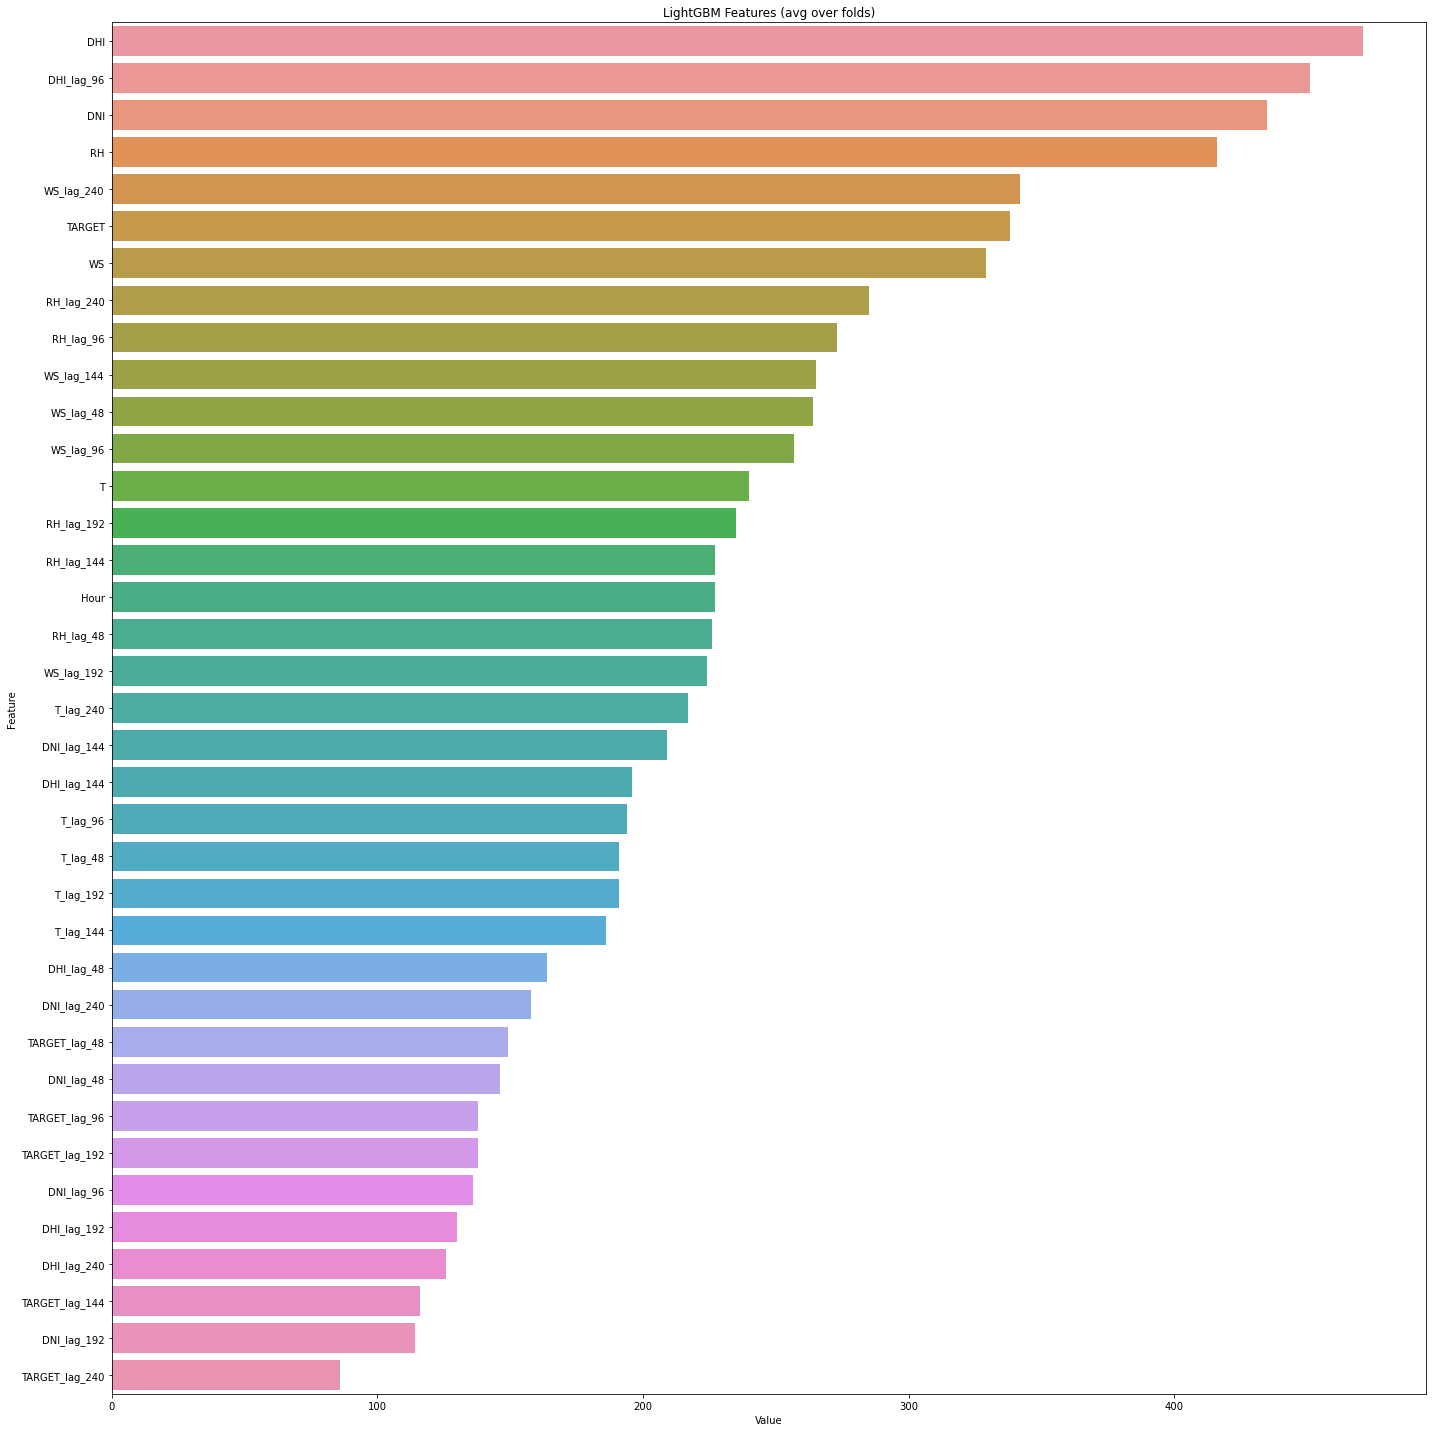

<Figure size 432x288 with 0 Axes>

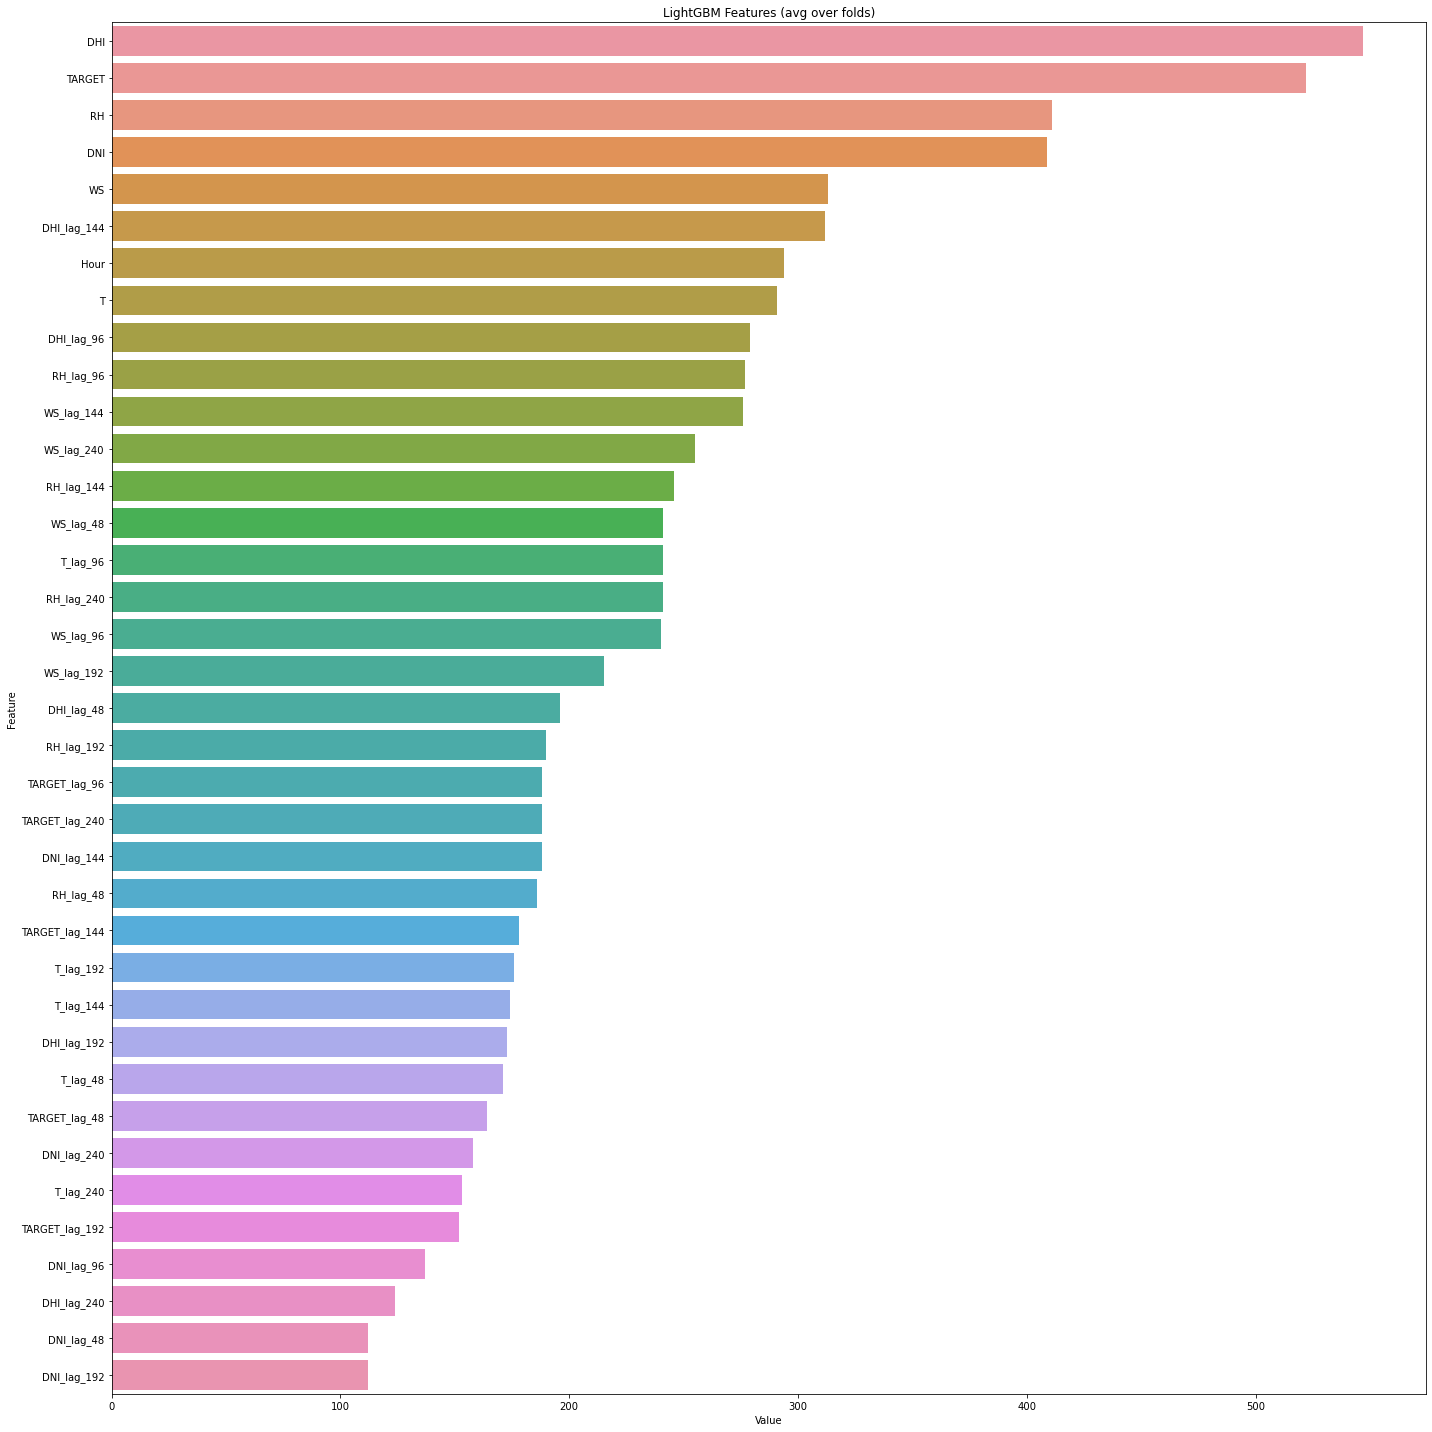

<Figure size 432x288 with 0 Axes>

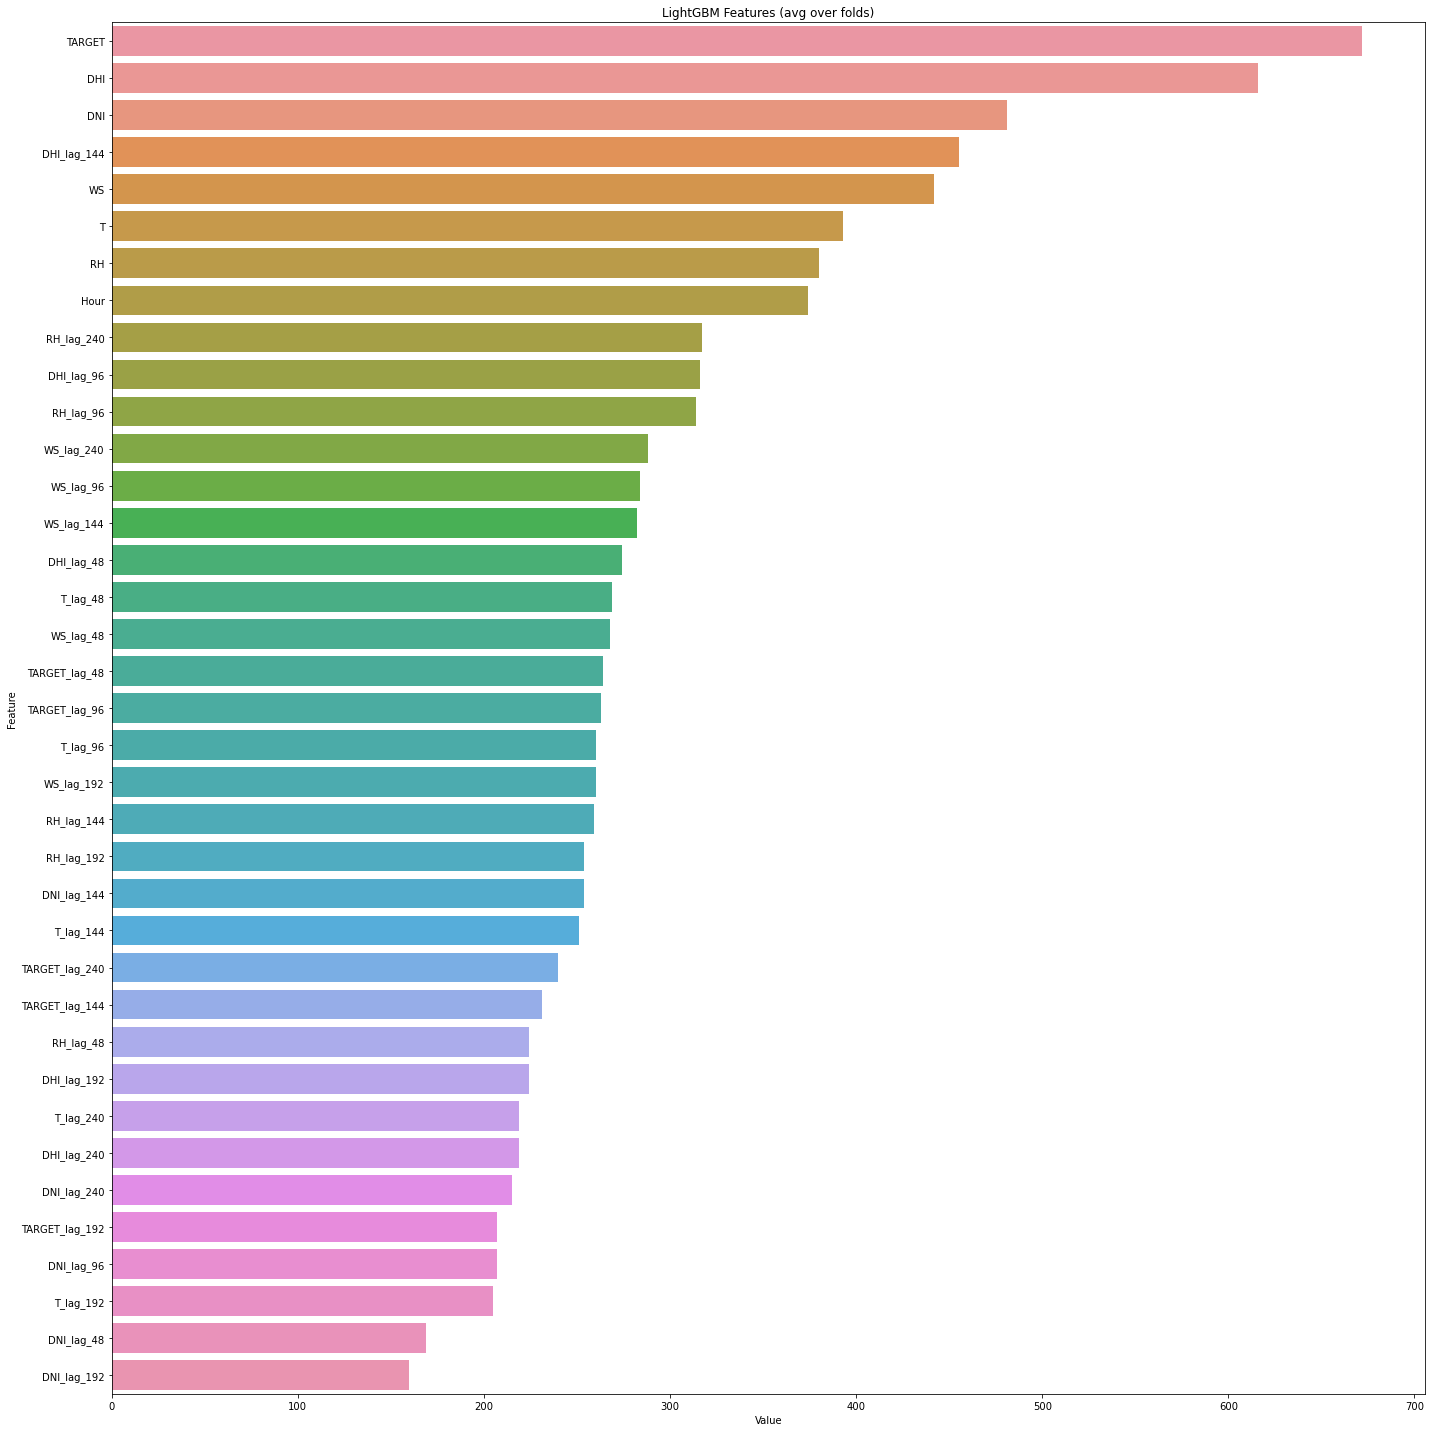

<Figure size 432x288 with 0 Axes>

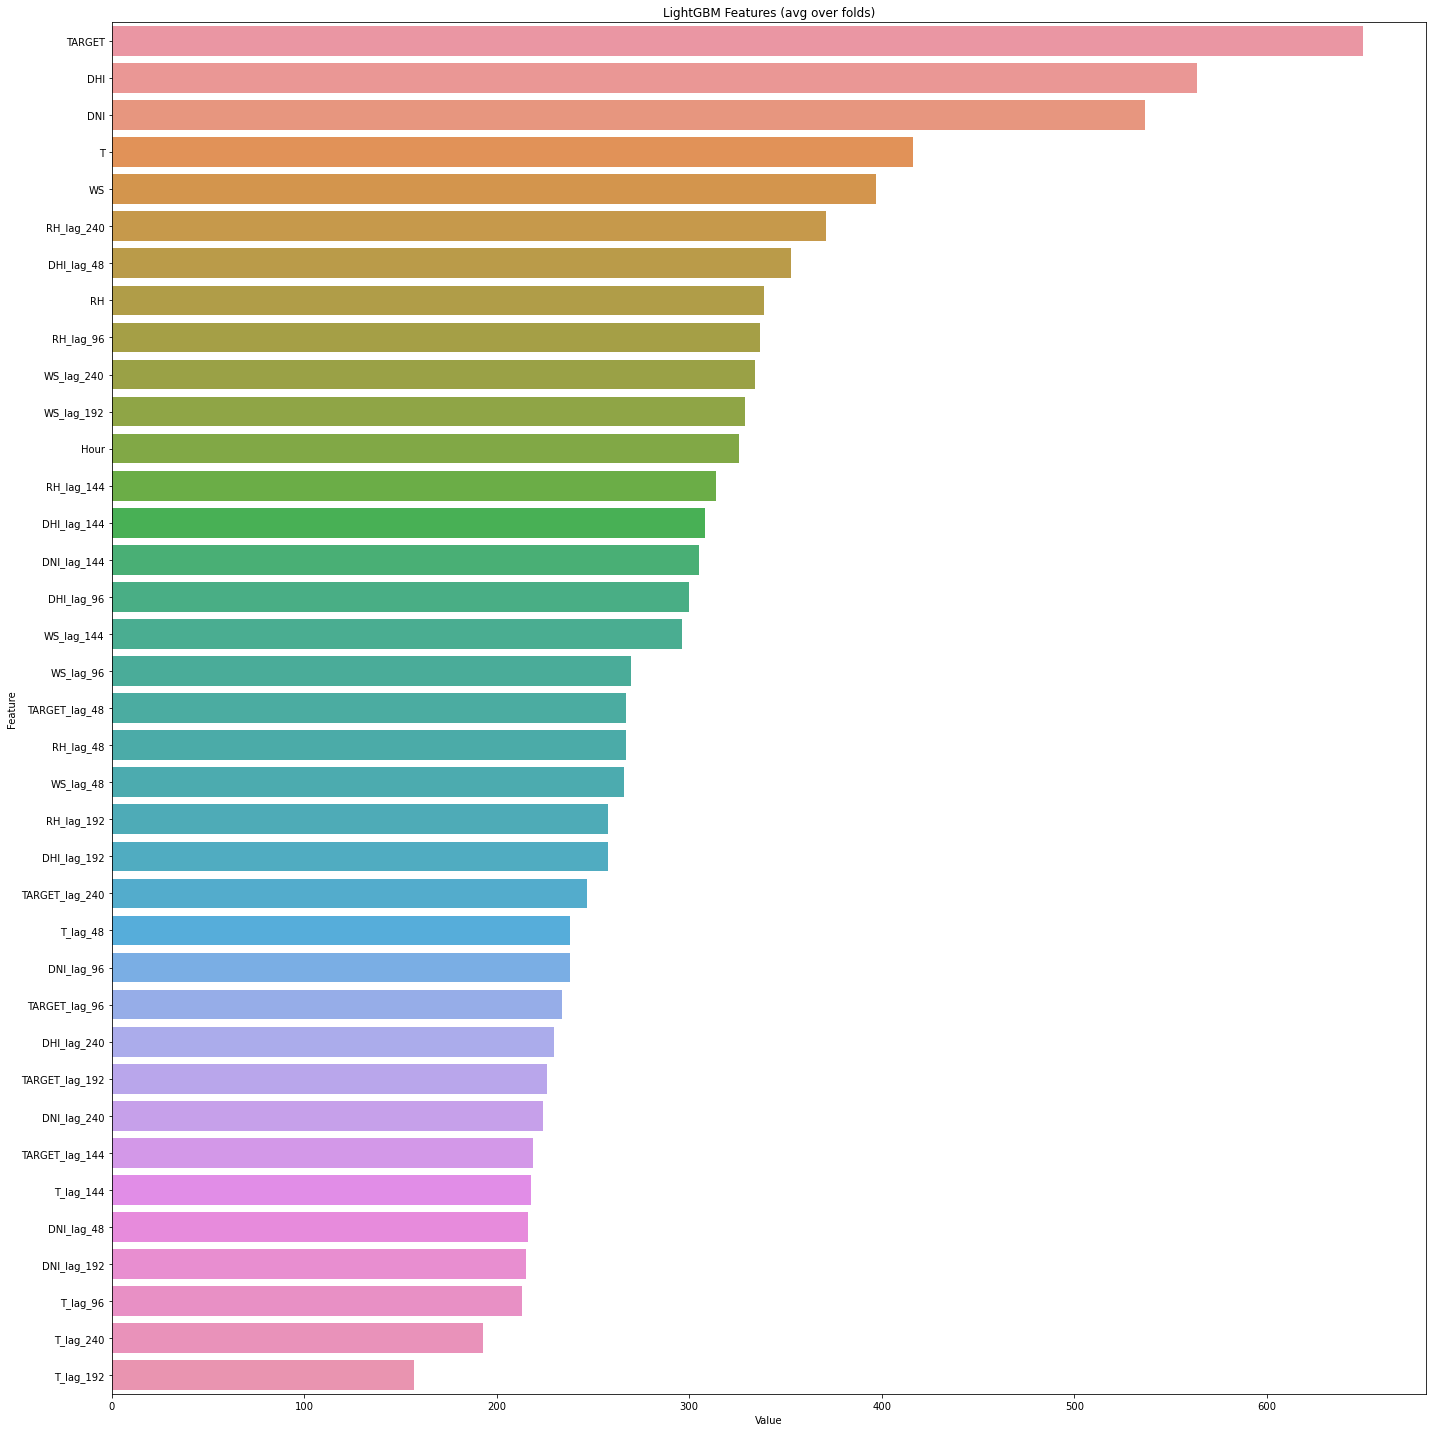

<Figure size 432x288 with 0 Axes>

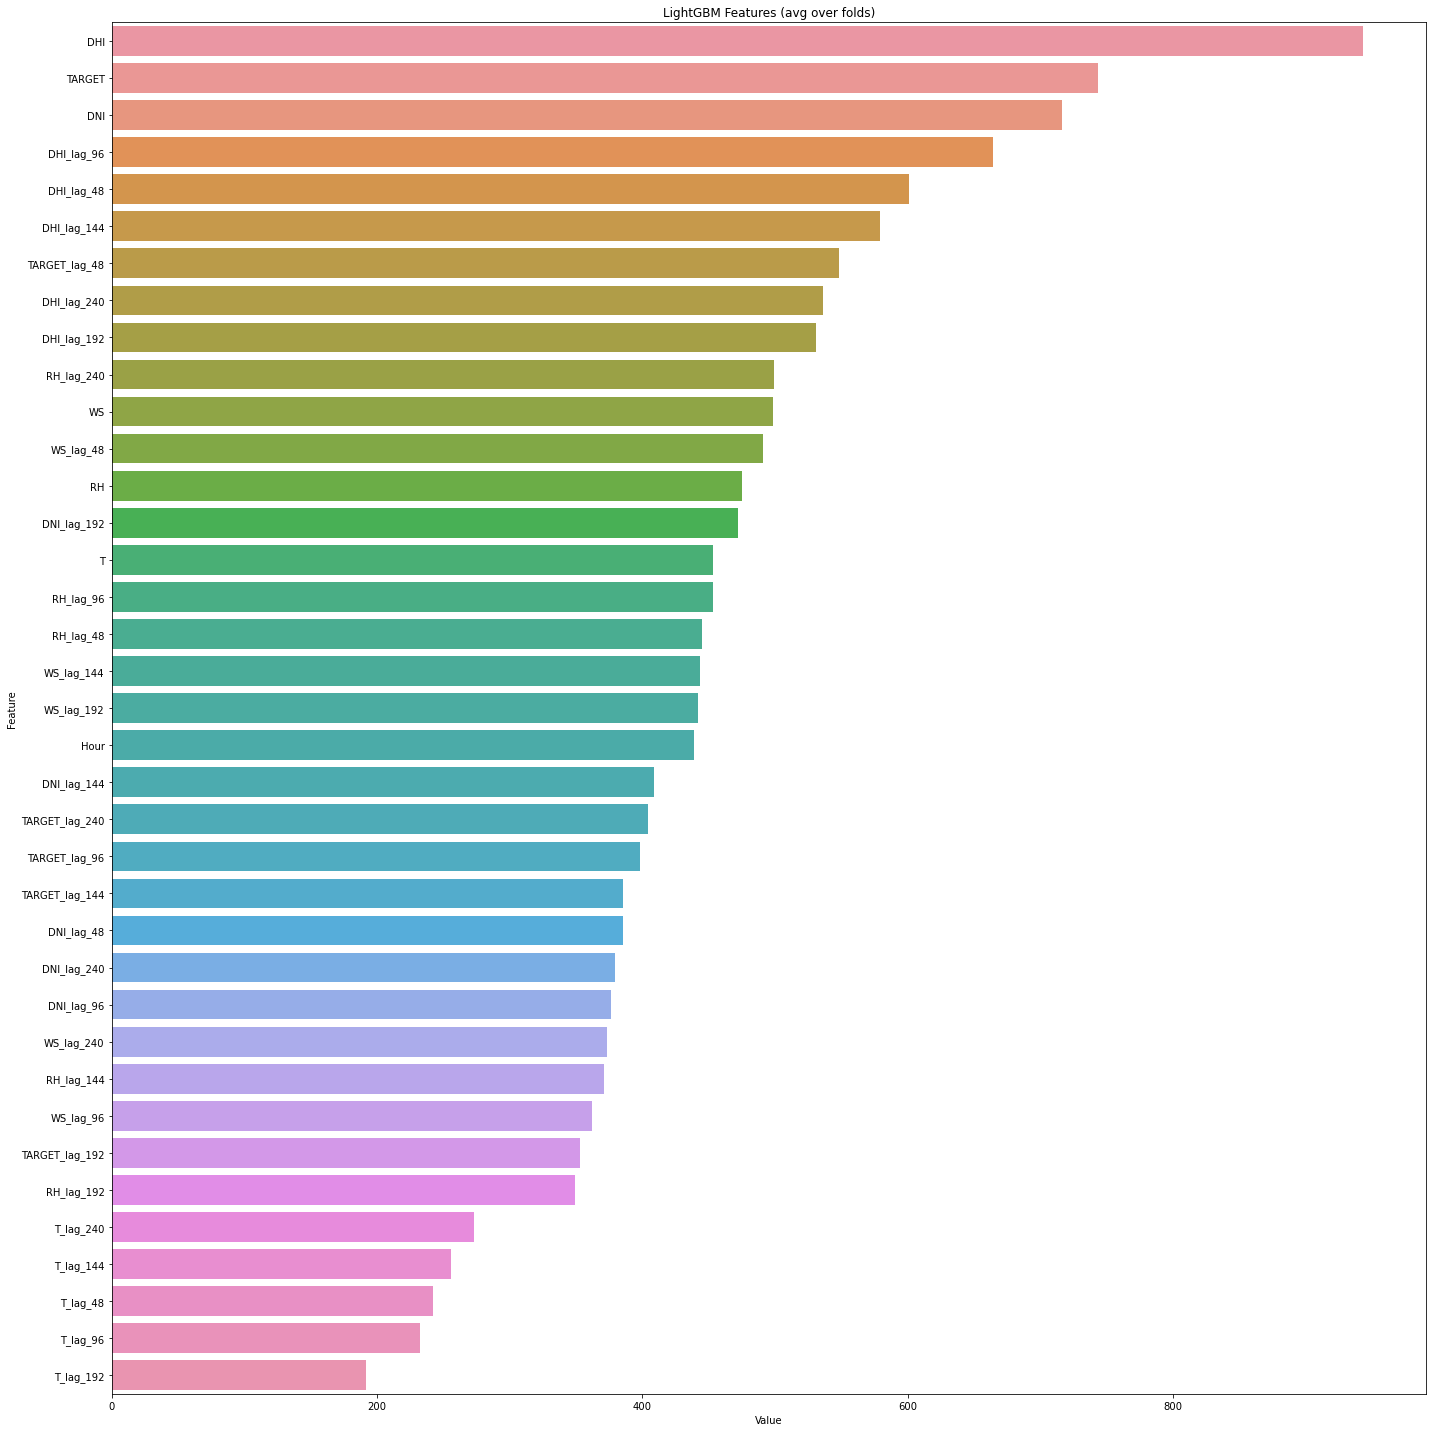

<Figure size 432x288 with 0 Axes>

In [30]:
for i in range(len(models_1)):
    # sorted(zip(clf.feature_importances_, X.columns), reverse=True)
    feature_imp = pd.DataFrame(sorted(zip(models_1[i].feature_importances_,x_train.columns)),
                               columns=['Value','Feature'])

    plt.figure(figsize=(20, 20))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()
    plt.savefig('lgbm_importances-01.png')

In [162]:
# lag model 3 window decross model

submission.loc[submission.id.str.contains("Day7"), "q_0.1":] = results_1.sort_index().values
#submission.loc[submission.id.str.contains("Day8"), "q_0.1":] = results_2.sort_index().values
#submission[16:33]

#submission.to_csv('./submission/submission_210106-1_6days_notminute.csv', index=False)

In [73]:
rf = RandomForestRegressor(random_state=42)

In [71]:
param_grid = {
    'n_estimators': [200, 300, 500, 700, 1000],
    'max_features' : ['auto', 'sqrt', 'log2'],
    'max_depth' : [3, 5, 7, 9],
    'n_jobs' : [-1]
    
}

In [76]:
cv_rf = GridSearchCV(estimator=rf,
                     param_grid=param_grid,
                     cv= 5)
cv_rf.fit(train_data, train_label)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [3, 5, 7, 9],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 300, 500, 700, 1000],
                         'n_jobs': [-1]})

In [77]:
cv_rf.best_params_

{'max_depth': 9, 'max_features': 'sqrt', 'n_estimators': 200, 'n_jobs': -1}

In [79]:
rf = RandomForestRegressor(n_estimators=200,
                           max_features='sqrt',
                           random_state=42,
                           max_depth = 9,
                           verbose=True,
                           n_jobs=-1)
rf.fit(train_data, train_label)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.1s finished


RandomForestRegressor(max_depth=9, max_features='sqrt', n_estimators=200,
                      n_jobs=-1, random_state=42, verbose=True)

In [80]:
rf_preds = []
for estimator in rf.estimators_:
    rf_preds.append(estimator.predict(test))
rf_preds = np.array(rf_preds)

for i, q in enumerate(np.arange(0.1, 1, 0.1)):
    y_pred = np.percentile(rf_preds, q * 100, axis=0)
    submission.iloc[:, i] = np.ravel(y_pred)

In [84]:
#submission.to_csv('./submission/submission_210107-2_rf-gridsearch.csv', index=False)

In [122]:
np.zeros(4, )

array([0., 0., 0., 0.])

In [146]:
pred, _ = LGBM(0.5, x_train, y_train_1, x_val, y_val_1, X_test)

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.75643
Early stopping, best iteration is:
[317]	valid_0's quantile: 2.74585


In [153]:
pred2 = pred+ pred

In [155]:
pred2[15:]

15       1.52
16       9.10
17      22.28
18      28.86
19      40.36
        ...  
3883     0.00
3884     0.00
3885     0.00
3886     0.00
3887     0.00
Length: 3873, dtype: float64

In [156]:
pred[15:]

15       0.76
16       4.55
17      11.14
18      14.43
19      20.18
        ...  
3883     0.00
3884     0.00
3885     0.00
3886     0.00
3887     0.00
Length: 3873, dtype: float64

In [163]:
submission[20:25]

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
20,0.csv_Day7_10h00m,8.46,11.91,13.85,18.88,23.39,21.56,30.58,29.13,34.13
21,0.csv_Day7_10h30m,10.05,16.08,19.16,23.17,28.89,28.91,36.28,34.99,34.55
22,0.csv_Day7_11h00m,12.34,19.87,23.66,28.50,35.93,35.06,40.38,39.78,42.27
23,0.csv_Day7_11h30m,12.47,19.11,23.32,29.04,33.73,36.31,40.73,43.37,45.11
24,0.csv_Day7_12h00m,13.57,21.64,25.28,32.24,34.79,37.63,41.80,47.02,44.27


In [164]:
submission2 = submission+submission
submission2[20:25]

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
20,0.csv_Day7_10h00m0.csv_Day7_10h00m,16.92,23.82,27.70,37.76,46.78,43.12,61.16,58.26,68.26
21,0.csv_Day7_10h30m0.csv_Day7_10h30m,20.10,32.16,38.32,46.34,57.78,57.82,72.56,69.98,69.10
22,0.csv_Day7_11h00m0.csv_Day7_11h00m,24.68,39.74,47.32,57.00,71.86,70.12,80.76,79.56,84.54
23,0.csv_Day7_11h30m0.csv_Day7_11h30m,24.94,38.22,46.64,58.08,67.46,72.62,81.46,86.74,90.22
24,0.csv_Day7_12h00m0.csv_Day7_12h00m,27.14,43.28,50.56,64.48,69.58,75.26,83.60,94.04,88.54


In [173]:
(submission2.loc[:, submission2.columns != 'id'].values)/2

array([[0.  , 0.  , 0.  , ..., 0.  , 0.01, 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.01, 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.01, 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]])

In [169]:
(pred2/2)[15:]

15       0.76
16       4.55
17      11.14
18      14.43
19      20.18
        ...  
3883     0.00
3884     0.00
3885     0.00
3886     0.00
3887     0.00
Length: 3873, dtype: float64

In [177]:
results_1.mean()

0.1     6.893549
0.2    12.180790
0.3    15.589185
0.4    17.645648
0.5    19.586505
0.6    20.837665
0.7    21.942629
0.8    22.852006
0.9    23.579064
dtype: float64